# APPM 5720 Biweekly Report - Part 2
### *Alexey Yermakov*
### *October 13, 2022*

# Summary
For this section, I implement the random erasing procedure. I recognize a flaw in the efficiency of the proposed algorithm in the original paper and improve upon its implementation to speed up the data augmentation process.

# Main Content
For this report I wanted to continue exploring data augmentation.
In this notebook, I implement the random erasing procedure by following the [original paper](https://ojs.aaai.org//index.php/AAAI/article/view/7000) in which it was introduced. First, I import some packages I'll be using.

In [1]:
# Make sure Torch is installed and our GPU is available
import torch
import numpy as np
from torch import permute
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time

# Check if GPU is available, though I don't use it in this notebook
print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

GPU Available? True


Now, I load my dataset. I'll be using the cats vs dogs dataset from kaggle which I preprocessed into training and validation groups in an earlier report. The details aren't important here except that this is the source of my images. Note that I'm scaling my input images to 224x224, the reason for this is that when we're training a model we typically want all of our input data to be the same size to allow for batch training. Otherwise, tensorflow and pytorch throw errors since out input data (our images of size HxWxC) are of different sizes.

In [2]:
# Load dataset
data_dir = '/home/alexey/Datasets/kaggle/cats_vs_dogs_parsed'

# Transform from image to tensor and scale to [224,224]
transform_from_im = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# Permute so our data is of the form HxWxC
def f_transform(im):
    tmp = transform_from_im(im)
    tmp = permute(tmp, (1,2,0))
    return tmp
    
# Load our dataset from disk
train_data = datasets.ImageFolder(
    root=data_dir+'/train',
    transform=f_transform
)

For this next part, I print some samples from the dataset to see some examples.

Training data sample:


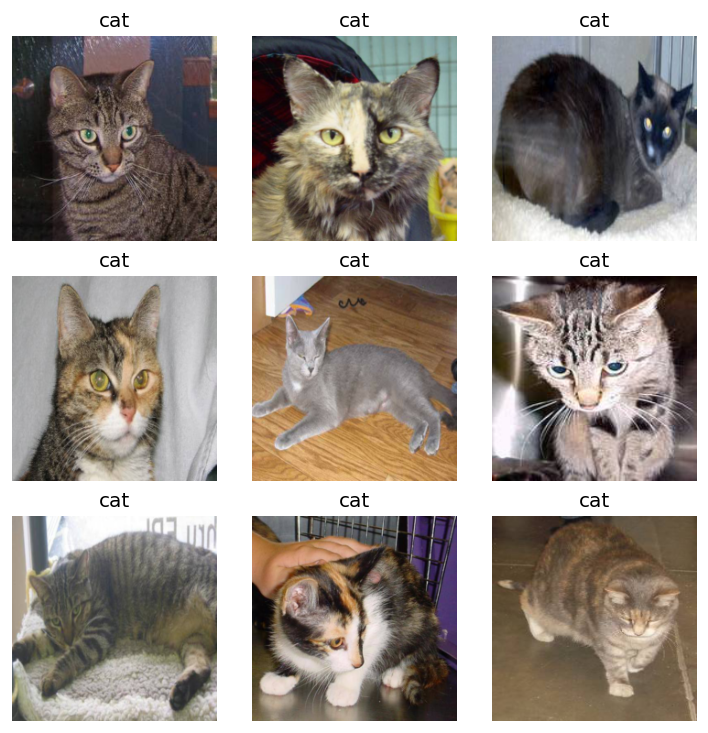

In [3]:
# Plot training data sample
print("Training data sample:")

# Get iterator for images
train_iter = iter(train_data)

# Create our figure as a grid
ncols = 3
nrows = 3
fig_scale=2
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True,\
                             figsize=(ncols*fig_scale,nrows*fig_scale), facecolor='white')
num_images = ncols*nrows

fig1.set_dpi(120.0)

# Plot the modified images
for r in range(nrows):
    for c in range(ncols):
        idx = ncols*r+c
        image, label = next(train_iter)
            
        label = "dog" if label else "cat"
        
        ax = f1_axes[r][c]
        ax.set_axis_off()
        ax.set_title(label)
        ax.imshow(np.asarray(image))

plt.show()

Great! So now that the dataset is loaded, lets take a look at the algorithm I'll be referencing:

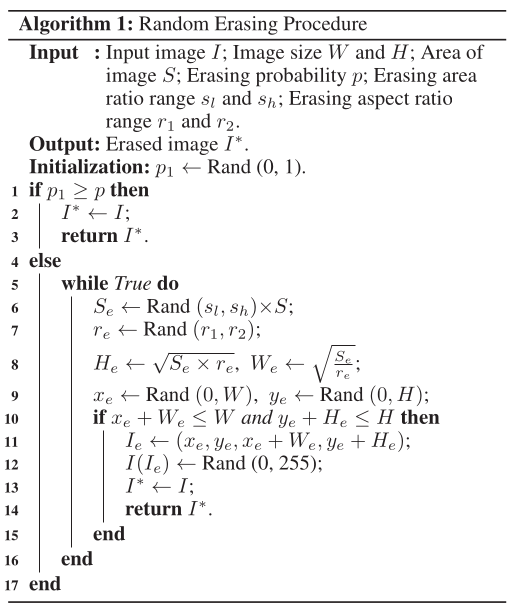

As a computer scientist, I have an immediate problem with this algorithm: there is an unnecessary `while true` loop. In some cases, `while true` is needed, but not here, since we can be clever about selecting the points and parameters for our random erasing procedure. As such, in my implementation of random erasing below I don't use any `for` or `while` loops. This speeds up the random erasing computation time, allowing us to train our models at a much quicker speed that if we had a `while true` loop.

Source:
- [Random Erasing](https://ojs.aaai.org//index.php/AAAI/article/view/7000)

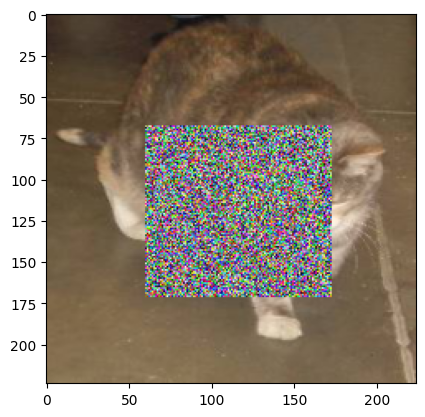

In [4]:
# Get tmp image we're erasing
tmp = image.numpy().copy()

# Set our erasing ratio range
sl = 0.2 # Minimum ratio of area erased
sh = 0.3 # Maximum ratio of area erased
r1 = 0.6 # Aspect ratio min
r2 = 1.4 # Aspect ratio max

# Check if random_erasing will work on the given inputs
# (this needs to only be run one for a dataset whose images are the same size)
def random_erasing_check(img, sl, sh, r1, r2):
    # Make sure we're erasing some data in the image without erasing the whole thing
    if sl > 1 or sl < 0 or sh > 1 or sh < 0 or sl > sh:
        raise Exception(f"sl {sl:f} < sh {sh:f} must be in (0,1)")
        
    # Make sure our erasing rectangle can fit in the image
    rl = min(r1, r2) # lower aspect ratio
    rh = max(r1, r2) # higher aspect ratio
    h = img.shape[0]
    w = img.shape[1]
    he_max = np.sqrt(sh*rh*h*w)
    we_max = np.sqrt(sh/rl*h*w)
    if he_max > h:
        raise Exception(f"Max height from inputs {he_max:f} exceeds image height {h:f}")
    if we_max > w:
        raise Exception(f"Max width from inputs {we_max:f} exceeds image width {w:f}")

# My own random erasing proceduce
def random_erasing(img, sl, sh, r1, r2):
    # Make sure our erasing rectangle can fit in the image
    rl = min(r1, r2) # lower aspect ratio
    rh = max(r1, r2) # higher aspect ratio
    h = img.shape[0]
    w = img.shape[1]
    
    # Do the random crop
    # 1) get area we want to crop
    se = np.random.uniform(sl, sh)*h*w
    # 2) get aspect ratio of crop
    re = np.random.uniform(rl, rh)
    # 3) get crop height and width
    he, we = np.sqrt(se * re), np.sqrt(se/re)
    # 4) get x and y by smartly choosing ranges for randomness
    xe, ye = np.random.uniform(0, w-we), np.random.uniform(0, h-he)
    # 5) set values to random integer in [0,255] in the crop region
    #    note: I do this efficiently by slicing! No nested for loops today:)
    x0, y0, x1, y1 = int(xe), int(ye), int(xe + we), int(ye+he)
    rnd = np.random.randint(0,256,(y1-y0+1,x1-x0+1,3))/255
    img[y0:y1+1,x0:x1+1] = rnd

# Make sure random erasing works with our image size and parameters
random_erasing_check(tmp, sl, sh, r1, r2)
# Perform random erasing
random_erasing(tmp, sl, sh, r1, r2)
# Show image
plt.imshow(tmp)

Great! So our random erasing procedure works for one image. Lets see how well it works for the entire dataset!

In [5]:
# Check my random erasing algorithm speed on the entire dataset
print("Erasing", len(train_data), "images")
t1 = time.time()
for im, lb in iter(train_data):
    random_erasing(im.numpy(), sl, sh, r1, r2)
t2 = time.time()
print(f"Done! {t2-t1:.2f} seconds")
print(f"{len(train_data)/(t2-t1):.2f} images erased per second")

Erasing 7102 images
Done! 22.16 seconds
320.53 images erased per second


That's fast! Lets see how it compares with PyTorch's random erasing transformation. Lets first use the transformation on a single image to see what we're dealing with.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


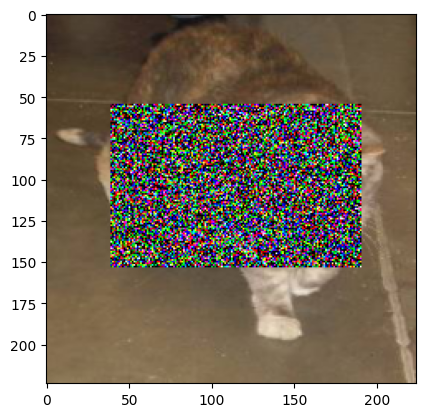

In [6]:
# Do random erasing on a single image
# Note that we had to permute from our original dataset twice so that
#   our image was of the for CxHxW, so we'll have to create a new dataset
#   with the original image shapes to test pytorch
#   see (http://pytorch.org/vision/main/generated/torchvision.transforms.functional.hflip.html)

# Define the transformation
transform = transforms.Compose([
    transforms.RandomErasing(1, scale=(sl, sh), ratio=(r1, r2), value='random')
])

# Make a copy of the image, permute it to CxHxW, then transform it with random erasing,
# then permute it back to HxWxC for plotting
tmp = image.detach().clone()
tmp2 = permute(tmp, (2,0,1))
tmp2 = transform(tmp2)
tmp2 = permute(tmp2, (1,2,0))

# Plot the image
plt.imshow(tmp2)

In [7]:
# Notice we are longer permuting when we get an image
def f_transform_2(im):
    tmp = transform_from_im(im)
    return tmp
    
# Load our dataset from disk
train_data_2 = datasets.ImageFolder(
    root=data_dir+'/train',
    transform=f_transform_2
)

In [8]:
# Check pytorch random erasing speed on the entire dataset
print("Erasing", len(train_data_2), "images")
t1 = time.time()
for im, lb in iter(train_data_2):
    transform(im)
t2 = time.time()
print(f"Done! {t2-t1:.2f} seconds")
print(f"{len(train_data)/(t2-t1):.2f} images erased per second")

Erasing 7102 images
Done! 22.23 seconds
319.43 images erased per second


Great! So, we can see that my method is pretty comparable, if not slightly faster (since the dataset I'm using to test my method has the extra overhead of permuting the image's dimensions first). Note that I used pytorch's implementation, not the one in the paper, which is also likely optimized. So, I would call this a great success!